In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
sys.path.append(os.path.abspath(os.path.join('..')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

import src.modelling_pipeline as modelling_pipeline
reload(modelling_pipeline)

mp = modelling_pipeline.ModelPipeline(ROOT_DIR)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                        y_train_df,
                                        test_size=0.15,
                                        )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)
x_val_df, x_val_count, y_val_df = create_data_df(x_val_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values
val_gendernum = x_val_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))
x_val = np.column_stack((x_val, val_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask

In [7]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [11]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = LSTM_model()
models.append(model)

In [13]:
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [14]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model
model = GRU_model()
models.append(model)

In [15]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [16]:
for i, lr_scheduler in enumerate(lr_schedulers):
  print(f"----------------Start learning rate {i}---------------------")
  model = LSTM_model()
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

  checkpointer = ModelCheckpoint(filepath = f'weights_best_lr_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  # callbacks_list = [lr_scheduler, early_stop, checkpointer]
  callbacks_list = [lr_scheduler, checkpointer]
  m = model.fit(x_train,y_train,
                sample_weight=sample_weights,
                # class_weight=me.get_class_weights(y_train_df),
                epochs=40, batch_size=64, verbose=1,
                validation_data=(x_val, y_val),
                callbacks=callbacks_list)
  m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               88064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 88322 (345.01 KB)
Trainable params: 88322 (345.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------Start K=0-------------------------------
Epoch 1/40
463/463 [==============================] - 5s 8ms/step - loss: 0.5563 - accuracy: 0.6992 - auc: 0.7528 - val_loss: 0.5367 - val_accuracy: 0.7588 - val_auc: 0.

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 4s 8ms/step - loss: 0.5045 - accuracy: 0.7664 - auc: 0.8246 - val_loss: 0.5028 - val_accuracy: 0.7709 - val_auc: 0.8363 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4897 - accuracy: 0.7738 - auc: 0.8404 - val_loss: 0.4991 - val_accuracy: 0.7693 - val_auc: 0.8375 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4774 - accuracy: 0.7775 - auc: 0.8484 - val_loss: 0.5073 - val_accuracy: 0.7654 - val_auc: 0.8318 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4660 - accuracy: 0.7836 - auc: 0.8549 - val_loss: 0.4918 - val_accuracy: 0.7794 - val_auc: 0.8440 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4538 - accuracy: 0.7903 - auc: 0.8636 - val_loss: 0.4871 - val_accuracy: 0.7804 - val_auc: 0.8457 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 14ms/step - loss: 0.4189 - accuracy: 0.8122 - auc: 0.8868 - val_loss: 0.4150 - val_accuracy: 0.8170 - val_auc: 0.8910 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 6s 13ms/step - loss: 0.4008 - accuracy: 0.8228 - auc: 0.8957 - val_loss: 0.4297 - val_accuracy: 0.8091 - val_auc: 0.8827 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3911 - accuracy: 0.8264 - auc: 0.9003 - val_loss: 0.3790 - val_accuracy: 0.8377 - val_auc: 0.9097 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 14ms/step - loss: 0.3769 - accuracy: 0.8368 - auc: 0.9099 - val_loss: 0.4115 - val_accuracy: 0.8219 - val_auc: 0.8937 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3670 - accuracy: 0.8426 - auc: 0.9144 - val_loss: 0.4123 - val_accuracy: 0.8212 - val_auc: 0.8926 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 14ms/step - loss: 0.3683 - accuracy: 0.8406 - auc: 0.9131 - val_loss: 0.3653 - val_accuracy: 0.8408 - val_auc: 0.9151 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3560 - accuracy: 0.8438 - auc: 0.9159 - val_loss: 0.3471 - val_accuracy: 0.8519 - val_auc: 0.9239 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 13ms/step - loss: 0.3428 - accuracy: 0.8530 - auc: 0.9240 - val_loss: 0.3638 - val_accuracy: 0.8442 - val_auc: 0.9157 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3312 - accuracy: 0.8560 - auc: 0.9276 - val_loss: 0.3705 - val_accuracy: 0.8377 - val_auc: 0.9124 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3230 - accuracy: 0.8607 - auc: 0.9315 - val_loss: 0.3505 - val_accuracy: 0.8511 - val_auc: 0.9220 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.3099 - accuracy: 0.8719 - auc: 0.9394 - val_loss: 0.3095 - val_accuracy: 0.8696 - val_auc: 0.9394 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2949 - accuracy: 0.8786 - auc: 0.9452 - val_loss: 0.2948 - val_accuracy: 0.8756 - val_auc: 0.9457 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2879 - accuracy: 0.8801 - auc: 0.9462 - val_loss: 0.3032 - val_accuracy: 0.8725 - val_auc: 0.9414 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2778 - accuracy: 0.8875 - auc: 0.9503 - val_loss: 0.2766 - val_accuracy: 0.8882 - val_auc: 0.9515 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 14ms/step - loss: 0.2668 - accuracy: 0.8911 - auc: 0.9542 - val_loss: 0.3098 - val_accuracy: 0.8750 - val_auc: 0.9393 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 14ms/step - loss: 0.2873 - accuracy: 0.8794 - auc: 0.9455 - val_loss: 0.2602 - val_accuracy: 0.8955 - val_auc: 0.9574 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 7s 16ms/step - loss: 0.2731 - accuracy: 0.8870 - auc: 0.9515 - val_loss: 0.2902 - val_accuracy: 0.8829 - val_auc: 0.9462 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 7s 15ms/step - loss: 0.2673 - accuracy: 0.8889 - auc: 0.9524 - val_loss: 0.2621 - val_accuracy: 0.8955 - val_auc: 0.9567 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 14ms/step - loss: 0.2516 - accuracy: 0.8968 - auc: 0.9579 - val_loss: 0.2480 - val_accuracy: 0.9011 - val_auc: 0.9598 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 14ms/step - loss: 0.2414 - accuracy: 0.9036 - auc: 0.9632 - val_loss: 0.2663 - val_accuracy: 0.8914 - val_auc: 0.9543 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 5s 11ms/step - loss: 0.5084 - accuracy: 0.7651 - auc: 0.8216 - val_loss: 0.5139 - val_accuracy: 0.7644 - val_auc: 0.8271 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4918 - accuracy: 0.7715 - auc: 0.8379 - val_loss: 0.5291 - val_accuracy: 0.7498 - val_auc: 0.8148 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4792 - accuracy: 0.7764 - auc: 0.8453 - val_loss: 0.5317 - val_accuracy: 0.7436 - val_auc: 0.8110 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4684 - accuracy: 0.7784 - auc: 0.8519 - val_loss: 0.4935 - val_accuracy: 0.7708 - val_auc: 0.8422 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.4554 - accuracy: 0.7890 - auc: 0.8642 - val_loss: 0.4950 - val_accuracy: 0.7671 - val_auc: 0.8412 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 14ms/step - loss: 0.4078 - accuracy: 0.8187 - auc: 0.8937 - val_loss: 0.4079 - val_accuracy: 0.8151 - val_auc: 0.8949 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3913 - accuracy: 0.8267 - auc: 0.9024 - val_loss: 0.3982 - val_accuracy: 0.8228 - val_auc: 0.9002 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3756 - accuracy: 0.8322 - auc: 0.9091 - val_loss: 0.3986 - val_accuracy: 0.8221 - val_auc: 0.9004 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 14ms/step - loss: 0.3671 - accuracy: 0.8414 - auc: 0.9148 - val_loss: 0.4051 - val_accuracy: 0.8218 - val_auc: 0.8969 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3541 - accuracy: 0.8461 - auc: 0.9187 - val_loss: 0.3867 - val_accuracy: 0.8334 - val_auc: 0.9077 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 14ms/step - loss: 0.2933 - accuracy: 0.8753 - auc: 0.9460 - val_loss: 0.3076 - val_accuracy: 0.8775 - val_auc: 0.9425 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2812 - accuracy: 0.8849 - auc: 0.9513 - val_loss: 0.3079 - val_accuracy: 0.8737 - val_auc: 0.9422 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2691 - accuracy: 0.8877 - auc: 0.9536 - val_loss: 0.2838 - val_accuracy: 0.8874 - val_auc: 0.9512 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2603 - accuracy: 0.8922 - auc: 0.9572 - val_loss: 0.2861 - val_accuracy: 0.8855 - val_auc: 0.9503 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2517 - accuracy: 0.9005 - auc: 0.9624 - val_loss: 0.2899 - val_accuracy: 0.8841 - val_auc: 0.9494 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.2647 - accuracy: 0.8930 - auc: 0.9579 - val_loss: 0.2440 - val_accuracy: 0.9019 - val_auc: 0.9639 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2422 - accuracy: 0.9029 - auc: 0.9646 - val_loss: 0.2372 - val_accuracy: 0.9055 - val_auc: 0.9665 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2370 - accuracy: 0.9045 - auc: 0.9664 - val_loss: 0.2416 - val_accuracy: 0.9027 - val_auc: 0.9650 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2284 - accuracy: 0.9086 - auc: 0.9685 - val_loss: 0.2458 - val_accuracy: 0.9033 - val_auc: 0.9638 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2162 - accuracy: 0.9129 - auc: 0.9718 - val_loss: 0.2136 - val_accuracy: 0.9180 - val_auc: 0.9730 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.2097 - accuracy: 0.9153 - auc: 0.9730 - val_loss: 0.1969 - val_accuracy: 0.9233 - val_auc: 0.9767 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 15ms/step - loss: 0.1997 - accuracy: 0.9213 - auc: 0.9766 - val_loss: 0.2010 - val_accuracy: 0.9218 - val_auc: 0.9759 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 7s 14ms/step - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9776 - val_loss: 0.2090 - val_accuracy: 0.9180 - val_auc: 0.9736 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 14ms/step - loss: 0.1914 - accuracy: 0.9249 - auc: 0.9785 - val_loss: 0.2112 - val_accuracy: 0.9159 - val_auc: 0.9730 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 14ms/step - loss: 0.1835 - accuracy: 0.9300 - auc: 0.9811 - val_loss: 0.2041 - val_accuracy: 0.9192 - val_auc: 0.9748 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 4s 9ms/step - loss: 0.5106 - accuracy: 0.7614 - auc: 0.8239 - val_loss: 0.5627 - val_accuracy: 0.7323 - val_auc: 0.7878 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4964 - accuracy: 0.7656 - auc: 0.8335 - val_loss: 0.4914 - val_accuracy: 0.7765 - val_auc: 0.8438 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4869 - accuracy: 0.7728 - auc: 0.8431 - val_loss: 0.4945 - val_accuracy: 0.7778 - val_auc: 0.8430 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4752 - accuracy: 0.7829 - auc: 0.8529 - val_loss: 0.5243 - val_accuracy: 0.7486 - val_auc: 0.8187 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.4674 - accuracy: 0.7804 - auc: 0.8544 - val_loss: 0.4995 - val_accuracy: 0.7684 - val_auc: 0.8382 - lr: 6.0653e-04
---------------------Start K=1----------------------

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 16ms/step - loss: 0.4639 - accuracy: 0.7858 - auc: 0.8587 - val_loss: 0.4785 - val_accuracy: 0.7830 - val_auc: 0.8533 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 16ms/step - loss: 0.4547 - accuracy: 0.7921 - auc: 0.8640 - val_loss: 0.4567 - val_accuracy: 0.7926 - val_auc: 0.8668 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 8s 17ms/step - loss: 0.4480 - accuracy: 0.7960 - auc: 0.8702 - val_loss: 0.4578 - val_accuracy: 0.7919 - val_auc: 0.8664 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 8s 16ms/step - loss: 0.4389 - accuracy: 0.8012 - auc: 0.8759 - val_loss: 0.4767 - val_accuracy: 0.7826 - val_auc: 0.8552 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================] - 8s 17ms/step - loss: 0.4296 - accuracy: 0.8051 - auc: 0.8788 - val_loss: 0.4701 - val_accuracy: 0.7870 - val_auc: 0.8604 - lr: 4.0657e-04
---------------------Start K=2--------------------

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 15ms/step - loss: 0.4422 - accuracy: 0.8022 - auc: 0.8744 - val_loss: 0.4639 - val_accuracy: 0.7869 - val_auc: 0.8607 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 8s 16ms/step - loss: 0.4335 - accuracy: 0.8022 - auc: 0.8763 - val_loss: 0.4507 - val_accuracy: 0.7942 - val_auc: 0.8692 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.4231 - accuracy: 0.8081 - auc: 0.8831 - val_loss: 0.4607 - val_accuracy: 0.7896 - val_auc: 0.8640 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 15ms/step - loss: 0.4140 - accuracy: 0.8149 - auc: 0.8890 - val_loss: 0.4531 - val_accuracy: 0.7946 - val_auc: 0.8690 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 14ms/step - loss: 0.4036 - accuracy: 0.8206 - auc: 0.8938 - val_loss: 0.4402 - val_accuracy: 0.8019 - val_auc: 0.8775 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 15ms/step - loss: 0.3882 - accuracy: 0.8239 - auc: 0.9015 - val_loss: 0.3807 - val_accuracy: 0.8332 - val_auc: 0.9082 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 7s 14ms/step - loss: 0.3786 - accuracy: 0.8325 - auc: 0.9074 - val_loss: 0.3971 - val_accuracy: 0.8249 - val_auc: 0.8997 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 15ms/step - loss: 0.3688 - accuracy: 0.8372 - auc: 0.9115 - val_loss: 0.3687 - val_accuracy: 0.8374 - val_auc: 0.9140 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 7s 14ms/step - loss: 0.3594 - accuracy: 0.8424 - auc: 0.9156 - val_loss: 0.3667 - val_accuracy: 0.8464 - val_auc: 0.9158 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 15ms/step - loss: 0.3464 - accuracy: 0.8511 - auc: 0.9233 - val_loss: 0.3758 - val_accuracy: 0.8384 - val_auc: 0.9109 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 15ms/step - loss: 0.3302 - accuracy: 0.8609 - auc: 0.9306 - val_loss: 0.3618 - val_accuracy: 0.8451 - val_auc: 0.9175 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 8s 16ms/step - loss: 0.3171 - accuracy: 0.8640 - auc: 0.9341 - val_loss: 0.3547 - val_accuracy: 0.8511 - val_auc: 0.9210 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 15ms/step - loss: 0.3098 - accuracy: 0.8707 - auc: 0.9385 - val_loss: 0.3385 - val_accuracy: 0.8589 - val_auc: 0.9280 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 7s 15ms/step - loss: 0.2991 - accuracy: 0.8732 - auc: 0.9420 - val_loss: 0.3454 - val_accuracy: 0.8585 - val_auc: 0.9259 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 7s 15ms/step - loss: 0.2926 - accuracy: 0.8785 - auc: 0.9452 - val_loss: 0.3630 - val_accuracy: 0.8499 - val_auc: 0.9190 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 14ms/step - loss: 0.5114 - accuracy: 0.7591 - auc: 0.8213 - val_loss: 0.5006 - val_accuracy: 0.7778 - val_auc: 0.8394 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4970 - accuracy: 0.7686 - auc: 0.8333 - val_loss: 0.4925 - val_accuracy: 0.7771 - val_auc: 0.8434 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 12ms/step - loss: 0.4861 - accuracy: 0.7738 - auc: 0.8423 - val_loss: 0.4967 - val_accuracy: 0.7723 - val_auc: 0.8401 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 12ms/step - loss: 0.4781 - accuracy: 0.7820 - auc: 0.8510 - val_loss: 0.5100 - val_accuracy: 0.7584 - val_auc: 0.8297 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4669 - accuracy: 0.7825 - auc: 0.8544 - val_loss: 0.4561 - val_accuracy: 0.7991 - val_auc: 0.8680 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 12ms/step - loss: 0.4186 - accuracy: 0.8142 - auc: 0.8879 - val_loss: 0.4513 - val_accuracy: 0.7997 - val_auc: 0.8727 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.4059 - accuracy: 0.8178 - auc: 0.8938 - val_loss: 0.4452 - val_accuracy: 0.8056 - val_auc: 0.8768 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3995 - accuracy: 0.8255 - auc: 0.8983 - val_loss: 0.4425 - val_accuracy: 0.8034 - val_auc: 0.8794 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3930 - accuracy: 0.8288 - auc: 0.9032 - val_loss: 0.4481 - val_accuracy: 0.8058 - val_auc: 0.8773 - lr: 4.0657e-04
Epoch 11/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3837 - accuracy: 0.8303 - auc: 0.9057 - val_loss: 0.4431 - val_accuracy: 0.8091 - val_auc: 0.8821 - lr: 3.6788e-04
Epoch 12/40
463/463 [============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 14ms/step - loss: 0.3818 - accuracy: 0.8332 - auc: 0.9080 - val_loss: 0.3831 - val_accuracy: 0.8362 - val_auc: 0.9089 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3698 - accuracy: 0.8393 - auc: 0.9117 - val_loss: 0.3842 - val_accuracy: 0.8368 - val_auc: 0.9086 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3574 - accuracy: 0.8453 - auc: 0.9183 - val_loss: 0.3706 - val_accuracy: 0.8426 - val_auc: 0.9147 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.3464 - accuracy: 0.8512 - auc: 0.9252 - val_loss: 0.3821 - val_accuracy: 0.8391 - val_auc: 0.9100 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 13ms/step - loss: 0.3380 - accuracy: 0.8553 - auc: 0.9275 - val_loss: 0.3493 - val_accuracy: 0.8585 - val_auc: 0.9259 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 6s 13ms/step - loss: 0.2991 - accuracy: 0.8732 - auc: 0.9449 - val_loss: 0.3126 - val_accuracy: 0.8735 - val_auc: 0.9406 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2861 - accuracy: 0.8830 - auc: 0.9512 - val_loss: 0.3148 - val_accuracy: 0.8727 - val_auc: 0.9399 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2840 - accuracy: 0.8824 - auc: 0.9515 - val_loss: 0.3141 - val_accuracy: 0.8736 - val_auc: 0.9405 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 6s 12ms/step - loss: 0.2766 - accuracy: 0.8853 - auc: 0.9543 - val_loss: 0.3051 - val_accuracy: 0.8754 - val_auc: 0.9438 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 6s 13ms/step - loss: 0.2681 - accuracy: 0.8922 - auc: 0.9572 - val_loss: 0.3068 - val_accuracy: 0.8797 - val_auc: 0.9437 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


463/463 [==============================] - 7s 15ms/step - loss: 0.2778 - accuracy: 0.8856 - auc: 0.9539 - val_loss: 0.2610 - val_accuracy: 0.8933 - val_auc: 0.9591 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 7s 16ms/step - loss: 0.2678 - accuracy: 0.8905 - auc: 0.9570 - val_loss: 0.2767 - val_accuracy: 0.8875 - val_auc: 0.9537 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 15ms/step - loss: 0.2576 - accuracy: 0.8939 - auc: 0.9601 - val_loss: 0.2569 - val_accuracy: 0.8982 - val_auc: 0.9599 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 8s 17ms/step - loss: 0.2537 - accuracy: 0.8967 - auc: 0.9614 - val_loss: 0.2427 - val_accuracy: 0.9017 - val_auc: 0.9645 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 14ms/step - loss: 0.2435 - accuracy: 0.9024 - auc: 0.9648 - val_loss: 0.2624 - val_accuracy: 0.8921 - val_auc: 0.9586 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

In [30]:
reload(me)

chart_types = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
mean_history = me.cal_model_mean(m_hist, k, chart_types)

In [31]:
len(m_hist)

20

In [32]:
len(mean_history)

4

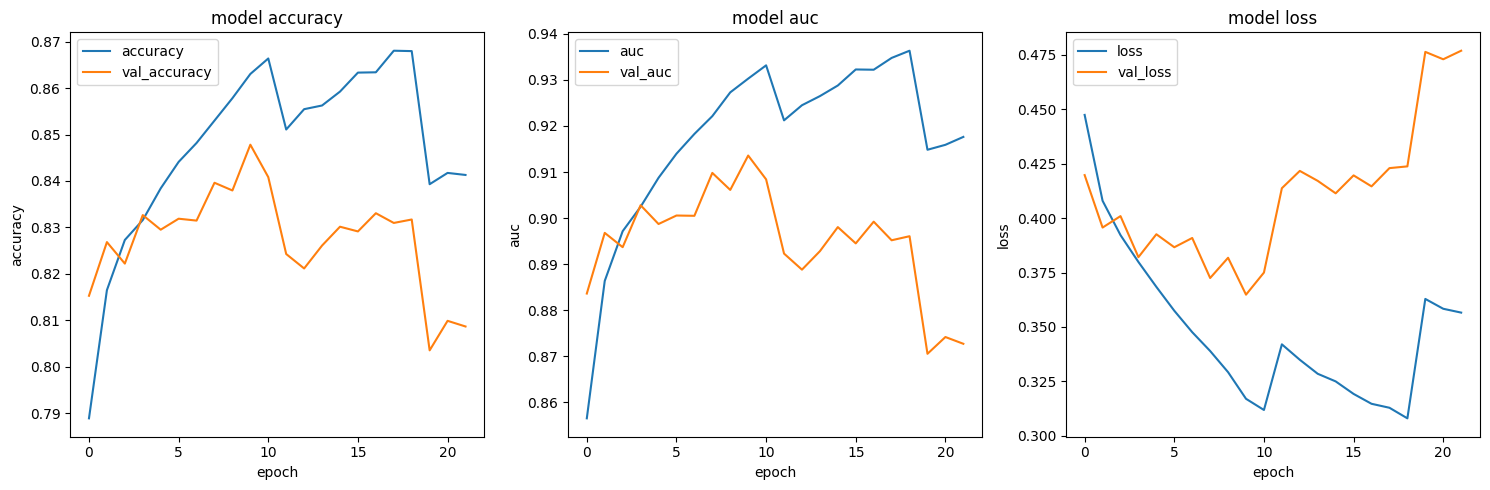

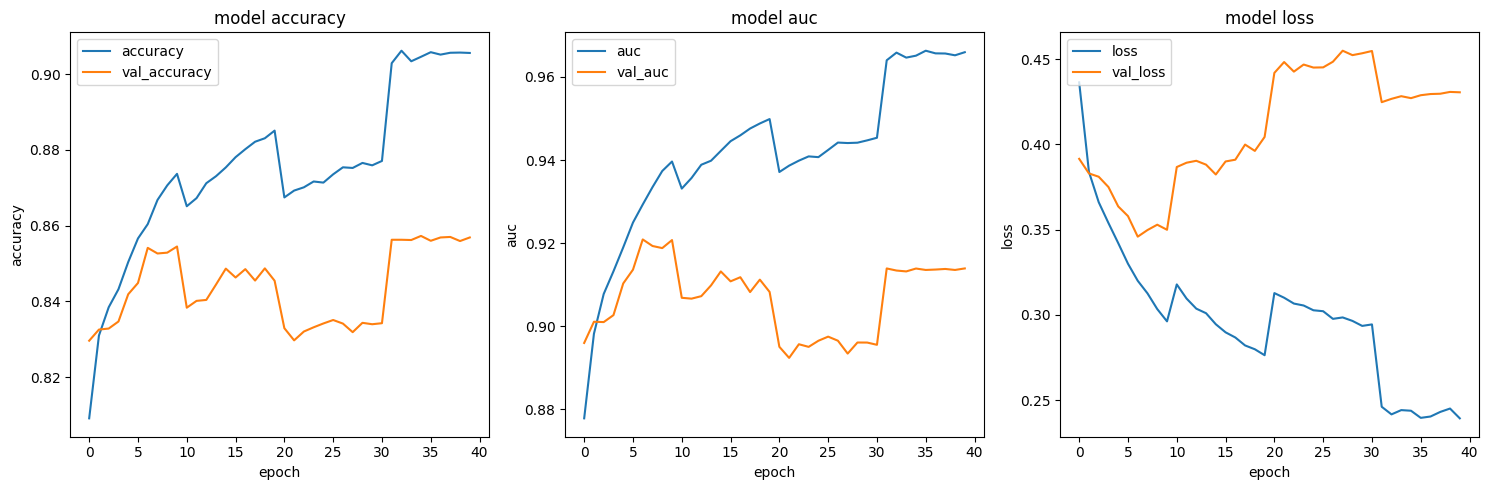

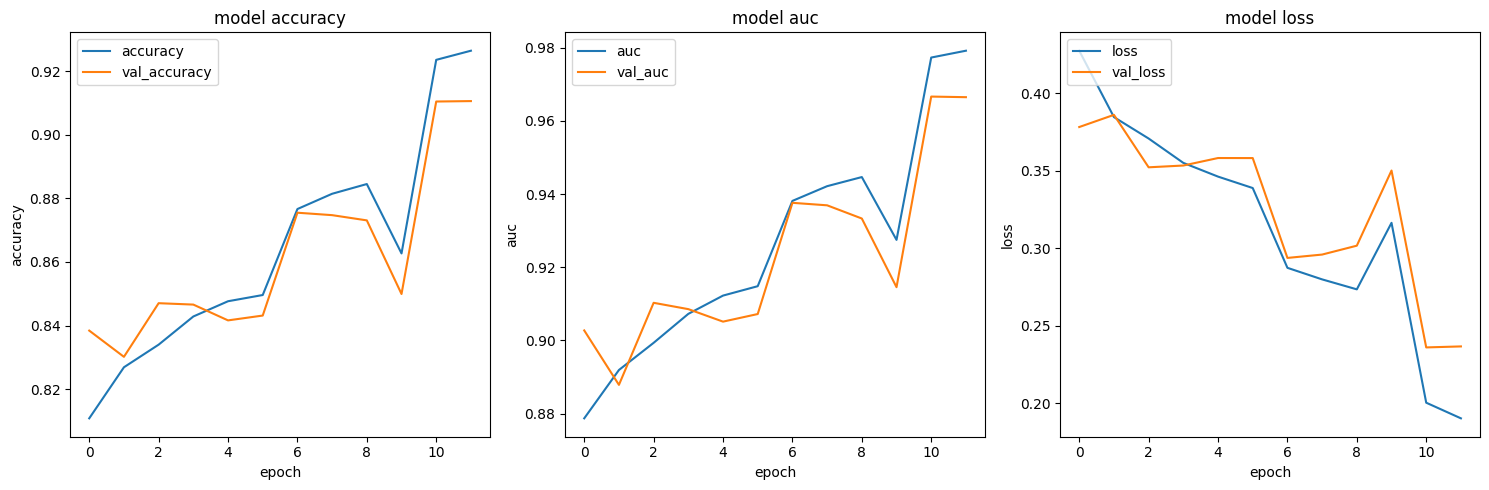

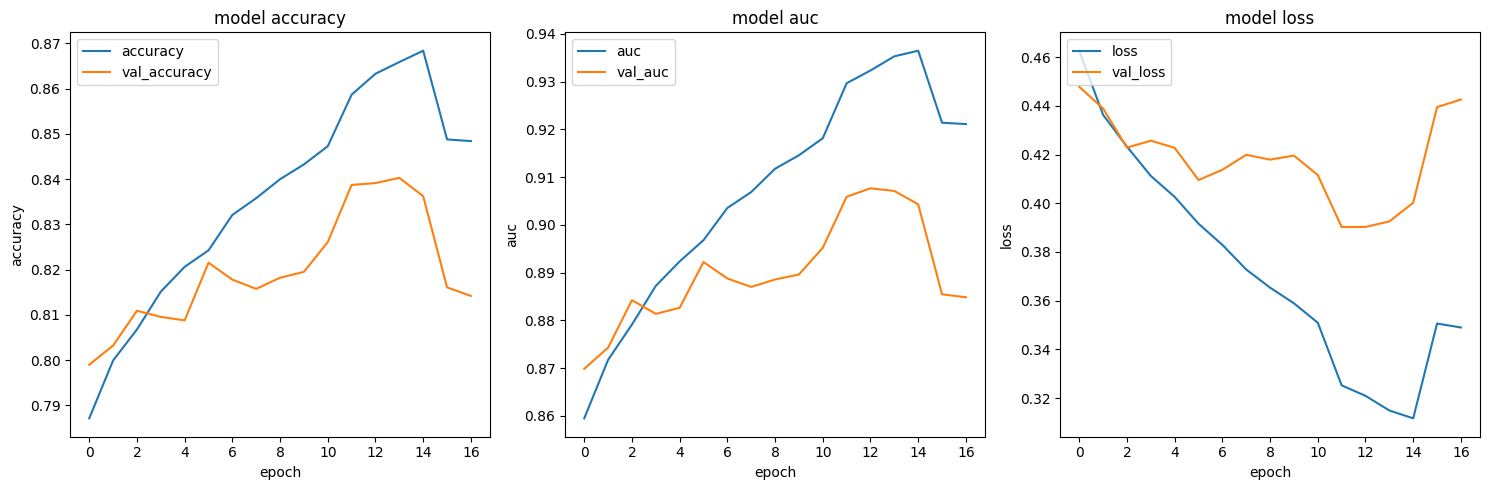

In [33]:
import matplotlib.pyplot as plt

for i, _ in enumerate(mean_history):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(mean_history[i][0])
  plt1.plot(mean_history[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(mean_history[i][2])
  plt2.plot(mean_history[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(mean_history[i][4])
  plt3.plot(mean_history[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

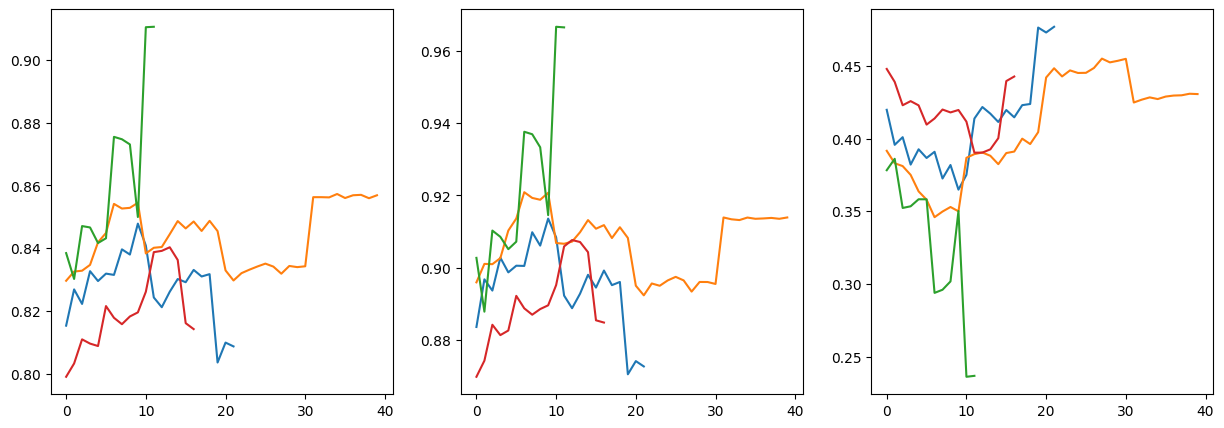

In [34]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(mean_history[0][chart+1])
  plts[i].plot(mean_history[1][chart+1])
  plts[i].plot(mean_history[2][chart+1])
  plts[i].plot(mean_history[3][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
Inference:
289/289 [==============================] - 0s 1ms/step


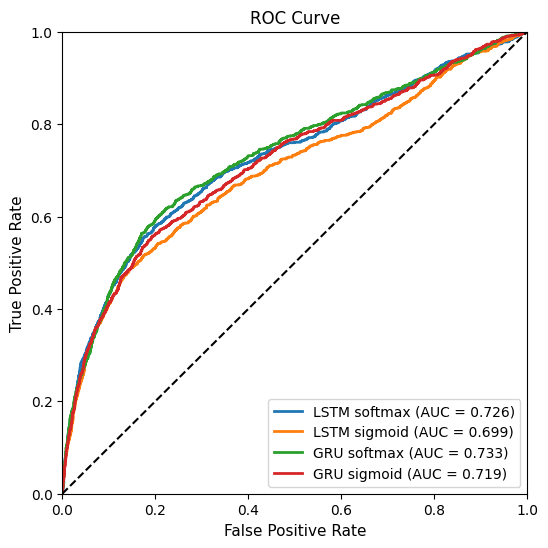

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,LSTM softmax,0.904924,0.678014,0.563124,0.309114,0.893441,0.487437,0.690828,0.378315
1,LSTM sigmoid,0.920296,0.663992,0.640994,0.310153,0.901483,0.448241,0.749243,0.366626
2,GRU softmax,0.875694,0.682576,0.497225,0.295481,0.855743,0.512563,0.628983,0.374862
3,GRU sigmoid,0.904513,0.670509,0.570209,0.308560,0.889922,0.467337,0.695063,0.371703


In [35]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['LSTM softmax', 'LSTM sigmoid', 'GRU softmax', 'GRU sigmoid']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_struct_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)